In [3]:
import re
import sys
import json


import sys
sys.dont_write_bytecode = True
sys.path.append('../')
from datatools.analyzer import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

In [44]:
path = "../../corpus/func_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
convs = read_conv(path, datalist)

In [45]:
usr_sys = []
y = []
utt_list = []
errors = ["Ignore question", "Ignore offer", "Ignore proposal", "Ignore greeting"]
for conv in convs:
    for i, ut in enumerate( conv ) :
        utt_list.append(ut.utt)
        # システム発話で，無視系統のエラー
        # if ut.is_system() and ut.is_exist_error():
        if ut.is_system():
        # if ut.is_system():
            usr_sys.append( [conv[i-1].utt, ut.utt] )
            if ut.is_error_included(errors):
                y.append(1)
            else:
                y.append(0)

In [7]:
from tqdm import tqdm
def make_vocab_dict(text:str):
    vocab_dict = dict()
    doc = nlp(text)
    print("analyzed vocab text")
    vocab_dict["[PAD]"] = 0
    for token in tqdm(doc):
        # 表層のまま登録してやるぜ
        key = token.orth_
        if key not in vocab_dict:
            vocab_dict[key] = len(vocab_dict)

    vocab_dict["[UNK]"] = len(vocab_dict)
    return vocab_dict


In [8]:
vocab_text = " ".join(utt_list)

In [9]:
vocab_dict = make_vocab_dict(vocab_text)
vocab_size = len(vocab_dict)

100%|██████████| 62812/62812 [00:00<00:00, 1700912.41it/s]

analyzed vocab text


In [10]:
vocab_path = "../X_y_data/base/"
vocab_name = "vocab_dict.pickle"
vocabM = DataManager(vocab_path)

In [11]:
vocabM.save_data(vocab_name, vocab_dict)

success save : ../X_y_data/base/vocab_dict.pickle


In [12]:
vocab_path = "../X_y_data/base/"
vocab_name = "vocab_dict.pickle"
vocabM = DataManager(vocab_path)
vocab_dict = vocabM.load_data(vocab_name)

success load : ../X_y_data/base/vocab_dict.pickle


In [56]:
data_path = "../X_y_data/base/"
data_name = "response_Xy_ver{0}.pickle".format(1)
dataM = DataManager(data_path)

In [13]:
def sentence2ids(sentence:str, vocab_dict:dict):
    doc = nlp(sentence)
    ids = np.zeros(len(doc))
    for i, token in enumerate(doc):
        key = token.orth_
        if key in vocab_dict:
            ids[i] = vocab_dict[key]
        else:
            ids[i] = vocab_dict["[UNK]"]
    return ids


In [150]:
from tqdm import tqdm
import torch.nn.utils.rnn as rnn

def padding_vector(Xseq):
    Xseq = [ torch.tensor( xseq[:, None] ) for xseq in Xseq]
    Xseq = rnn.pad_sequence(Xseq, batch_first=True)
    Xseq = [ torch.flatten(xseq) for xseq in Xseq ] 
    return Xseq


def make_X(usr_sys:list, vocab_dict:dict):
    usr_id_list = []
    sys_id_list = []
    for turn in tqdm( usr_sys ) :
        usr_id = sentence2ids(turn[0], vocab_dict)
        usr_id_list.append(usr_id)

        sys_id = sentence2ids(turn[1], vocab_dict)
        sys_id_list.append(sys_id)
    
    # usr_id_pad = rnn.pad_sequence(torch.Tensor( usr_id_list) , batch_first=True)
    # sys_id_pad = rnn.pad_sequence(torch.Tensor( sys_id_list), batch_first=True)
    usr_id_pad = padding_vector(usr_id_list)
    sys_id_pad = padding_vector(sys_id_list)

    usr_pad_len = len(usr_id_pad[0])
    sys_pad_len = len(sys_id_pad[0])
    # X =   [ torch.Tensor([u, s]) for u, s in zip(usr_id_pad, sys_id_pad) ] 
    # print(usr_pad_len, sys_pad_len)
    X = torch.zeros( (len(usr_sys), usr_pad_len+sys_pad_len) )
    for i, (u, s) in enumerate( zip(usr_id_pad, sys_id_pad) ):
        # print(i, u, s)
        X[i, :usr_pad_len] = u
        X[i, usr_pad_len: usr_pad_len+sys_pad_len] = s
    return X, usr_pad_len, sys_pad_len


In [151]:
X, upl, spl = make_X(usr_sys, vocab_dict)

100%|██████████| 1423/1423 [00:32<00:00, 43.94it/s]


In [152]:
# dataM.save_data(data_name, [X, y])


In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [154]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [155]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size, batch_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim,  padding_idx=0)
        # モデルを2つ定義
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.hidden2tag = nn.Linear(hidden_dim , tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()
    
    def forward(self, x, upl, spl):
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)

        # x : [seq]
        usr_ = x[:, :upl]
        sys_ = x[:, upl:upl+spl]
        emb1 = self.word_embeddings(usr_)
        emb2 = self.word_embeddings(sys_)
        _, lstm1_out = self.lstm1(emb1)
        _, lstm2_out = self.lstm1(emb2)
        # print(hidden_layer)
        # bilstm_out = torch.cat([lstm_out[0][0], lstm_out[0][1]], dim=1)
        
        usr_vec = ( lstm1_out[0][0] + lstm1_out[0][1] )/2 
        sys_vec = ( lstm2_out[0][0] + lstm2_out[0][1] )/2

        # print(usr_vec.shape, sys_vec.shape)
        # print(torch.cat([ usr_vec, sys_vec], dim=1).shape)
        tag_space = self.hidden2tag(torch.cat([ usr_vec, sys_vec], dim=1 ))
        
        # y = self.hidden2tag(hidden_layer[0].view(batch_size, -1))

        # y = self.hidden2tag(bilstm_out)
        y =self.softmax(tag_space)
        return y

In [156]:
BATCH_SIZE = 32
epoch_ = 200
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [157]:
VOCAB_SIZE = len(vocab_dict)
EMBEDDING_DIM = 128
HIDDEN_DIM = EMBEDDING_DIM*2
OUTPUT_DIM = 2

In [158]:
model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [160]:
losses = []
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0', dtype=torch.int16)
        X_t_tensor = data[0].to(torch.int).cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape , y_t_tensor.view(-1,1).shape)

        score = model(X_t_tensor, upl, spl)
        # print(X_t_tensor.shape, score.view(-1,5).shape, y_t_tensor.view(-1,1).shape)
        loss_ = loss_function(score,  y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


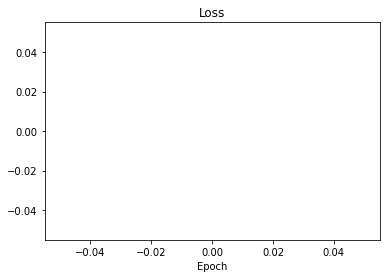

In [162]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [163]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0', dtype=torch.int)
    y_tensor = torch.tensor(y_test, device='cuda:0', dtype=torch.long)
            # 推論
    y_pred= np.array(model(X_tensor, upl, spl).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [164]:
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[210  20]
 [ 10  45]]
accuracy =  0.8947368421052632
precision =  0.6923076923076923
recall =  0.8181818181818182
f1 score =  0.7500000000000001


In [165]:
model_path = "../models/base/"
model_name = "responce_form.pickle"
modelM = DataManager(model_path)

In [166]:
modelM.save_data(model_name, model)

success save : ../models/base/responce_form.pickle
